In [1]:
#import camb
#pars = camb.CAMBparams()
from scipy.special import jn, jn_zeros
#from camb import model, initialpower
from scipy.interpolate import interp1d
from hankel_transform import *
from power_spectra import *
from astropy.cosmology import Planck15 as cosmo #use Planck15 if you can
import astropy.units as u
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams["font.family"] = "serif"
from scipy.signal import savgol_filter
import scipy.integrate as integrate

plt.rcParams['text.usetex'] = False
#rc('text', usetex=False)
cosmo_h=cosmo.clone(H0=70)

In [2]:
DS_prof=np.genfromtxt('./BolPlanck_r_DS_50.txt',names=('rp','DS'))
SMF_prof=np.genfromtxt('./cosmos2015_dic2017_smf_z01-04_STY0.txt',names=('log_m','log_phi','log_phi_inf','log_phi_sup'))
log_m=SMF_prof['log_m']
log_phi=SMF_prof['log_phi']

In [3]:
dlogr=np.gradient(np.log10(DS_prof['rp']))[0]
rmin=0.01 #10**(np.log10(DS_prof['rp'][0])-dlogr/2)
rmax=20 #10**(np.log10(DS_prof['rp'][-1])+dlogr/2)
nbins=len(DS_prof['rp'])

rp_bins=np.logspace(np.log10(rmin),np.log10(rmax),nbins+1)

In [4]:
#z_lens=np.atleast_1d([.3])#
z_lens_min=0.05
z_lens_max=0.2
z_lens_mean = .135#(z_lens_min+z_lens_max)/2#get from the data
#change to lens z (z_lens_mean)
z_lens=np.atleast_1d([z_lens_mean])

In [5]:
#Set up a new set of parameters for power spectra and correlation functions
PS=Power_Spectra()
PS.pk_params['kmax']=520
PS.pk_params['kmin']=1e-2
PS.pk_params['non_linear']=1
rmin=.01
rmax=20

In [6]:
cosmo_params=dict({'h':cosmo.h,'Omb':cosmo.Ob0,'Omd':cosmo.Odm0,'Om':cosmo.Om0,
                'As':2.14e-09,'mnu':cosmo.m_nu[-1].value,'Omk':cosmo.Ok0,'tau':0.06,'ns':0.965,
                  'w':-1,'wa':0})

In [7]:
pk,kh=PS.class_pk(z_lens,cosmo_params=cosmo_params,pk_params=pk_params,return_s8=False)
h=cosmo.h
k=kh*h
pk=pk/h**3
rho=PS.Rho_crit(cosmo=cosmo)*cosmo.Om0

In [8]:
#Setting up the Hankel Transform
#This part is slower. But only needs to be run once. 
#If you only need wgg, set j_nu=[0]. For wg+ (or \Delta\Sigma) use j_nu=[2]
%time HT=hankel_transform(rmin=rmin,rmax=rmax,kmax=PS.pk_params['kmax'],j_nu=[2],n_zeros=80000,kmin=PS.pk_params['kmin'],prune_r=0)
%time HT_inv=hankel_transform(rmin=PS.pk_params['kmin'],rmax=PS.pk_params['kmax'],kmax=rmax,j_nu=[2],n_zeros=80000,kmin=rmin,prune_r=50)
#HT=hankel_transform(rmin=1,rmax=rmax,kmax=1,j_nu=[0,2],n_zeros=2800,kmin=1.e-2)#quick test... inaccurate

j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover kmin, increasing by  1000  to 86000
nr: 3310
CPU times: user 1min 14s, sys: 1.03 s, total: 1min 15s
Wall time: 1min 15s
changed kmax to 513.5622301840683  to cover rmin
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 81000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 82000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 83000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 84000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 85000
j-nu= 2  not enough zeros to cover rmax, increasing by  1000  to 86000
pruning r, log_

In [9]:
x=HT_inv.k[2]>DS_prof['rp'].max()
DS2=DS_prof['DS'][-1]*DS_prof['rp'][-1]/HT_inv.k[2][x]
DS2=np.append(DS_prof['DS'],DS2)
rp2=np.append(DS_prof['rp'],HT_inv.k[2][x]) #this doesnot help
#DS2 = savgol_filter(DS2, 5, 3) # window size 51, polynomial order 3

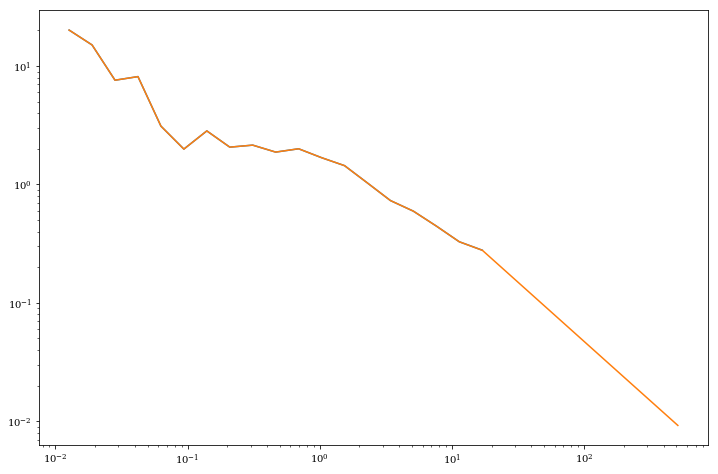

In [10]:
plt.plot(DS_prof['rp'],DS_prof['DS'])
plt.plot(rp2,DS2)
plt.xscale('log')
plt.yscale('log')
plt.show()

In [11]:
k2,p_gk2=HT_inv.projected_correlation(k_pk=rp2,pk=DS2,j_nu=2)
p_gk2*=(2*np.pi)**2 #factors due to fourier convention
# p_gk2*=(HT.kmax[2]**2/HT.rmax[2]**2) #https://www.gnu.org/software/gsl/doc/html/dht.html
#p_gk2 = savgol_filter(p_gk2, 21, 3) # window size 51, polynomial order 3

In [12]:
#check with Suhkdeep
#In the future could do more sophisticated model for bias of clustering by measuring the clustering in the simulation
# Could do a b1 and b2 term
# shoudlnt have a large impact on the errors though
b_g=1
p_g=b_g**2*pk[0]
p_gk=b_g*pk[0]*rho

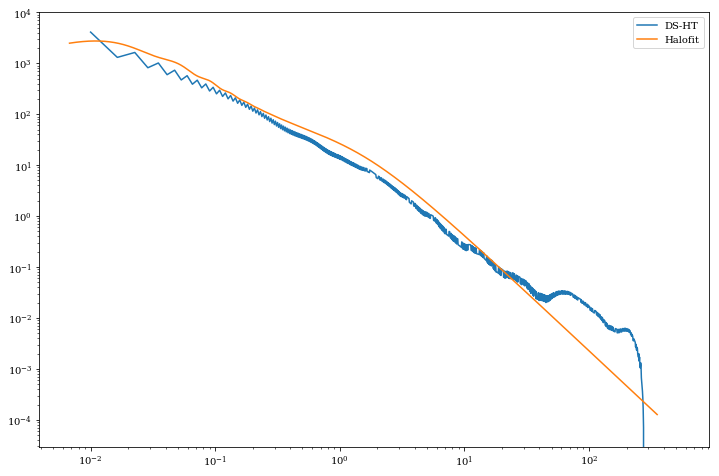

In [13]:
plt.loglog(k2,p_gk2,label='DS-HT') #sim profile, extrapolated and then inv-HT
plt.loglog(k,p_gk,label='Halofit')
plt.legend()
plt.show()

In [14]:
r_th,DS_th2=HT.projected_correlation(k_pk=k2,pk=p_gk2,j_nu=2)
r_th,DS_th=HT.projected_correlation(k_pk=k,pk=p_gk,j_nu=2)

In [15]:
rp,DS_th_b=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th) #bin the theory predictions
rp,DS_th_b2=HT.bin_mat(r=r_th,r_bins=rp_bins,mat=DS_th2) #bin the theory predictions

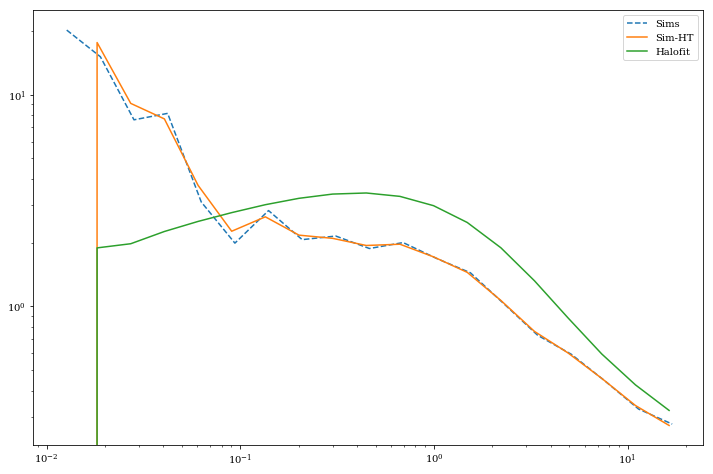

In [16]:
plt.plot(DS_prof['rp'],DS_prof['DS'],'--',label='Sims')
plt.plot(rp,DS_th_b2,label='Sim-HT') # Extrapolatred profile from sims, inv-HT to get power spectra and then HT back
plt.plot(rp,DS_th_b,label='Halofit')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

# g-g Lensing covariance

In [17]:
#change to parameters we used
z_source=np.atleast_1d([0.8])
#z_source=np.atleast_1d([1.2])
sigma_gamma=0.28
#sigma_e=.36
#sigma_gamma=sigma_e/sqrt(2)
n_s_arcmin=18 #perarcmin**2
#n_s_arcmin=20 #perarcmin**2

In [18]:
#n_g=phiintegral
#n_g=3.e-4
#g_shot_noise=1./n_g
Ms_min = 8
Ms_max = 9
SMF = interp1d(log_m, log_phi, kind=3)
x_SMF = np.linspace(0,13,10000)
Phi_interp1d = SMF(x_SMF)
SMF_new = interp1d(x_SMF, pow(10,Phi_interp1d), kind=3)
phiintegral = integrate.quad(lambda x: SMF_new(x), Ms_min, Ms_max)[0]
n_g = phiintegral
g_shot_noise=1./n_g

In [19]:
#z_lens_min=0.1
#z_lens_max=0.6
L_W=cosmo.angular_diameter_distance(z_lens_max)-cosmo.angular_diameter_distance(z_lens_min)
L_W=L_W.value

#area=10000 #in deg^-2
area=300 #in deg^-2
#area_comoving=area*(np.pi/180)**2*cosmo.angular_diameter_distance(z=.27)**2
area_comoving=area*(np.pi/180)**2*cosmo.angular_diameter_distance(z_lens_mean)**2

In [20]:
#check H0 and comoving physical
sigma_crit=PS.sigma_crit(zl=z_lens,zs=z_source,cosmo=cosmo)
sigma_crit=sigma_crit[0,0].value

In [21]:
d2r=np.pi/180.
n_s=n_s_arcmin*3600/d2r**2
shape_noise=sigma_gamma**2/n_s

In [22]:
l,cl_kappa_kappa=PS.kappa_cl(zs1=z_source,p_zs1=[1],zs2=z_source,p_zs2=[1],zl_max=z_source,n_zl=100,
                             l=np.arange(5.e5),cosmo=cosmo)
chi=cosmo.angular_diameter_distance(z_lens)
k_l=(l+0.5)/chi
cl_intp=interp1d(k_l,cl_kappa_kappa,bounds_error=False,fill_value=0)

#p_kappa_kappa=sigma_crit**2*(cl_intp(k)+shape_noise)*chi**2  #all noise
p_kappa_kappa=sigma_crit**2*(cl_intp(k)*0+shape_noise)*chi**2 #shape noise only

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/power_spectra.py:231: RuntimeWarning: divide by zero encountered in true_divide
  pk_int=interp1d(lz,pk[i]/DC_i**2,bounds_error=False,fill_value=0)
/Users/yifei/anaconda/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/power_spectra.py:257: RuntimeWarning: divide by zero encountered in true_divide
  f=(l+0.5)**2/(l*(l+1.)) #correction from Kilbinger+ 2017


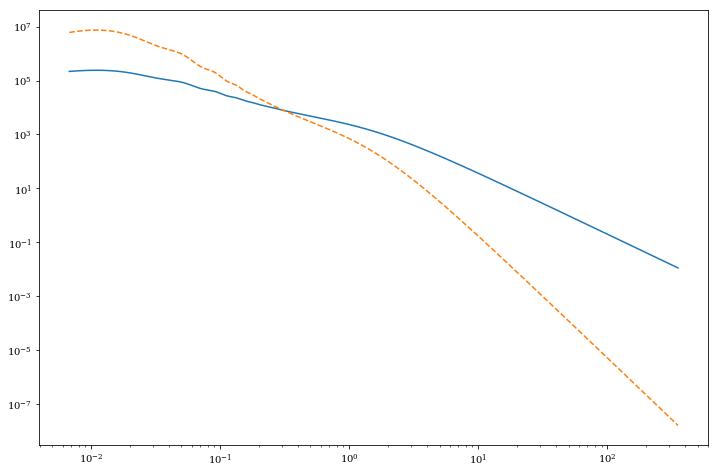

In [23]:
plt.plot(k,p_kappa_kappa*p_g/L_W)
plt.plot(k,p_gk**2,'--')
plt.xscale('log')
plt.yscale('log')
plt.show()

In [24]:
taper_kw=dict({'large_k_lower':500,'large_k_upper':PS.pk_params['kmax'],'low_k_lower':PS.pk_params['kmin'],
               'low_k_upper':PS.pk_params['kmin']*1.2})

In [25]:
#r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #all noise

r,cov_ggkk=HT.projected_covariance(k_pk=k,pk1=p_g*0+g_shot_noise,pk2=p_kappa_kappa,j_nu=2,taper=True,**taper_kw) #shape noise only

r_re,cov_ggkk_re=HT.bin_cov(r=r,cov=cov_ggkk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_ggkk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [26]:
r,cov_gkgk=HT.projected_covariance(k_pk=k,pk1=p_gk,pk2=p_gk,j_nu=2,taper=True,**taper_kw)#return_Jrr=True,Jrr=Jrr
#Donot use gkgk when doing noise only
r_re,cov_gkgk_re=HT.bin_cov(r=r,cov=cov_gkgk,r_bins=rp_bins)
corr=HT.corr_matrix(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


In [27]:
cov_ggkk_re/=(area_comoving.value*L_W)
cov_gkgk_re/=area_comoving.value

#cov_final=(cov_ggkk_re+cov_gkgk_re)#/area_comoving.value #all noise
cov_final=cov_ggkk_re #shape noise only

corr=HT.corr_matrix(cov=cov_final)
errors=HT.diagonal_err(cov=cov_final)
errors_ggkk=HT.diagonal_err(cov=cov_ggkk_re)
errors_gkgk=HT.diagonal_err(cov=cov_gkgk_re)

/Users/yifei/work/dwarf/Predicting lensing for dwarfs/sukhdeep/Predicting lensing for dwarfs/sukhdeep/Alexie_dwarfs/hankel_transform.py:138: RuntimeWarning: invalid value encountered in double_scalars
  corr[i][j]=cov[i][j]/np.sqrt(cov[i][i]*cov[j][j])


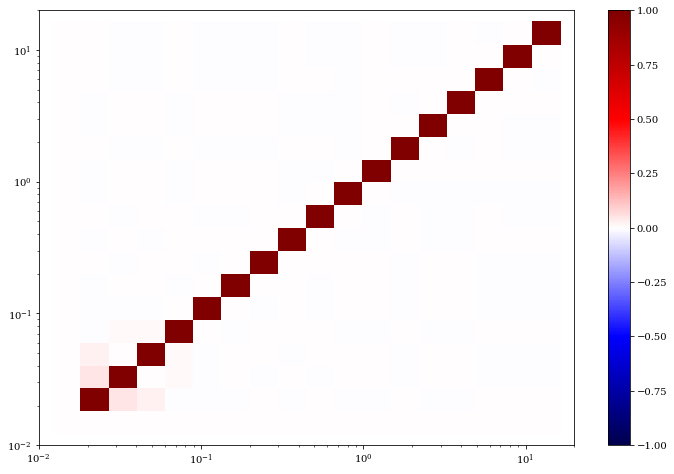

In [28]:
plt.pcolor(r_re,r_re,corr,vmin=-1,vmax=1,cmap='seismic')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlim(HT.rmin[2],HT.rmax[2])
plt.ylim(HT.rmin[2],HT.rmax[2])
plt.show()

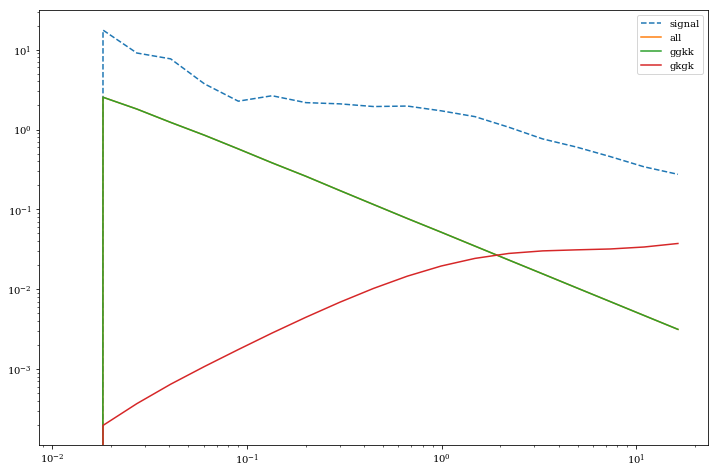

In [29]:
plt.plot(rp,DS_th_b2,'--',label='signal')
plt.plot(r_re,errors,label='all')
plt.plot(r_re,errors_ggkk,label='ggkk')
plt.plot(r_re,errors_gkgk,label='gkgk')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()
# xlim(1,100)
#green line is the DS error

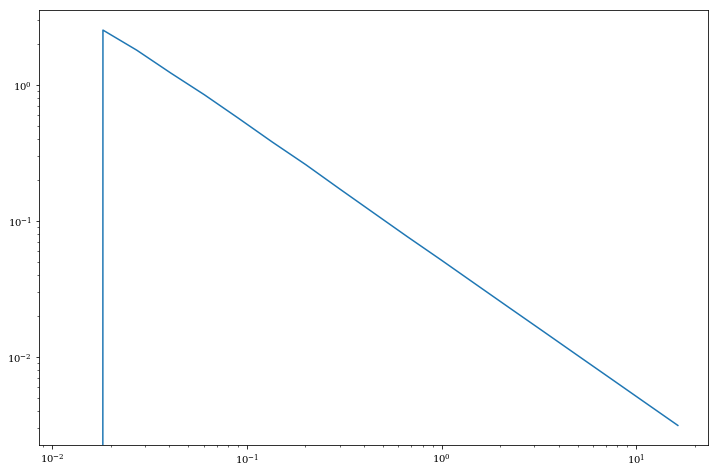

In [30]:
plt.loglog(r_re,errors_ggkk,label='ggkk')
plt.show()

In [31]:
#Shape noise only from Yifei

import numpy as np
from astropy import units, constants
#import astropy.cosmology
#import scipy.interpolate
from scipy.interpolate import interp1d 
#from astropy.io import fits
#from astropy import units as u
from matplotlib import pyplot as plt
#from astropy.visualization import quantity_support
import scipy.integrate as integrate
import cosmology

plt.rcParams["font.family"] = "serif"

# H0=70  Omega_M = 0.3, physical units for R and DS
cosmo_y=cosmology.Cosmo(H0=67.7, omega_m = 0.307)

file = open("BolPlanck_r_DS_50.txt","r")
matrix=[[float(i) for i in line.split()] for line in file.readlines()]
lines=(np.array(matrix)).T
radius_mpc=lines[0]
DS=lines[1]
err_DS=[]
# z_lens_min = 0.05
# z_lens_max = 0.2
# z_lens_mean = (z_lens_min+z_lens_max)/2
zs = 0.8

#cosmos=1.64; HSC=300
area_survey = 300
Ms_min = 8
Ms_max = 9
source_d = 18#galaxies/arcmin**2
shape_noise = 0.28

file = open("cosmos2015_dic2017_smf_z01-04_STY0.txt","r")
matrix=[[float(i) for i in line.split()] for line in file.readlines()]
lines=(np.array(matrix)).T
log_m=lines[0]
log_phi=lines[1]
log_phi_inf=lines[2]
log_phi_sup=lines[3]

SMF = interp1d(log_m, log_phi, kind=3)
x_SMF = np.linspace(0,13,10000)
Phi_interp1d = SMF(x_SMF)
SMF_new = interp1d(x_SMF, pow(10,Phi_interp1d), kind=3)

#n = integrate.quad(lambda x: SMF(x), 6, 7)
CSQUARE_OVER_4PIG = (constants.c ** 2/(4 * np.pi * constants.G)).to(units.Msun / units.pc).value

def sigma_crit(zl, zs, cosmo_y, comoving=False):
    """Calculate the distance term in Sigma_crit.
        
        Convert it into pc^1
        
        Parameter
        ---------
        zl : float or numpy array
        Redshift of lens.
        zs : float or numpy array
        Redshift of source.
        cosmos : cosmology.Cosmology object
        Cosmology object from `cosmology` package by Erin Sheldon.
        comoving : boolen, optional
        Flag for using comoving instead of physical unit. Default: False
        
        Return
        ------
        Critical surface density measurements
        
        """
    dist_term = ((1e-6 * cosmo_y.Da(0, zs) /
                  (cosmo_y.Da(zl, zs) * cosmo_y.Da(0, zl))))
        
    if comoving:
        return CSQUARE_OVER_4PIG * dist_term * (1.0 / (1. + zl)) ** 2

    return CSQUARE_OVER_4PIG * dist_term

sigma_crit_1=1/sigma_crit((z_lens_min+z_lens_max)/2, zs, cosmo_y, comoving=False)


def DS_error(z_lens_min, z_lens_max, Ms_min, Ms_max, source_d, shape_noise):
   i=0
   while i < len(DS)-1 :     
        # Bins in arcmin :
        am_1 = radius_mpc[i]/(cosmo_y.Da(0,z_lens_mean))*10800/np.pi
        am_2 = radius_mpc[i+1]/(cosmo_y.Da(0,z_lens_mean))*10800/np.pi
        # area
        area = np.pi*((am_2**2)-(am_1**2))
        # Total number of sources in this bin: 
        phiintegral= integrate.quad(lambda x: SMF_new(x), Ms_min, Ms_max)[0]
        #volume = integrate the voume givein zmin zmax and area
        volume = cosmo_y.V(z_lens_min,z_lens_max) * area_survey/(4*np.pi*(180/np.pi)**2)
        nlens = phiintegral * volume
        n_this_bin = area*source_d*nlens
        # Error on gamma
        err_gamma  = shape_noise/np.sqrt(n_this_bin)
        # Error on Delta Sigma    
        err_ds = err_gamma/sigma_crit_1
        err_DS.append(err_ds)
        i=i+1
        print(err_ds)
        #print(nlens)
        #print(n_this_bin)
        #print(err_gamma)
        #print(area)

DS_error(z_lens_min, z_lens_max, Ms_min, Ms_max, source_d, shape_noise)
err_DS=np.array(err_DS)

from astropy.cosmology import Planck15 as cosmo 

2.713561809787405
1.819095535115985
1.2194704959155391
0.8174987303861827
0.5480281617484146
0.3673826697290031
0.2462830114178896
0.16510120566603284
0.1106792058268525
0.074196227417272
0.049739064549918686
0.03334367027029012
0.022352658964424486
0.01498459403927879
0.010045250494778024
0.006734053471073869
0.004514320093347166
0.0030262732532101676


In [32]:
errors_ggkk_1 = errors_ggkk[1:19]
r_re = r_re[1:19]
errors_ggkk_1
r_re
radius_mpc = radius_mpc[1:19]

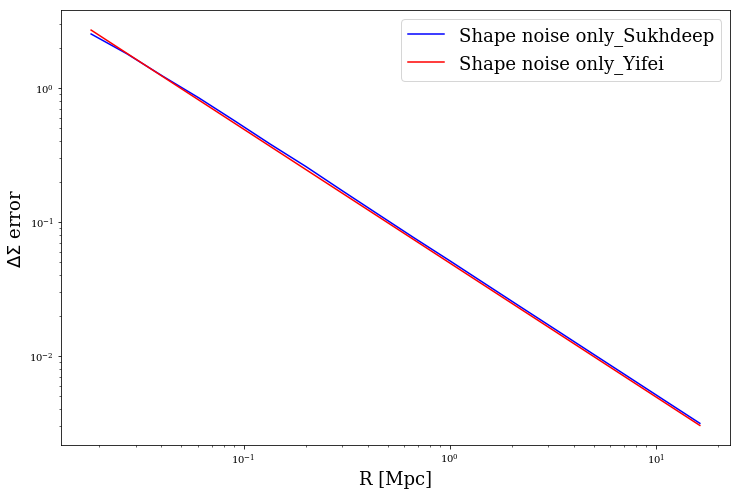

In [34]:
#plot1, = plt.plot(r_re,errors_ggkk_2,label='All noise_Sukhdeep',c='g')
plot2, = plt.plot(r_re,errors_ggkk_1,label='Shape noise only_Sukhdeep',c='b')
plot3, = plt.plot(r_re,err_DS,label='Shape noise only_Yifei',c='r')
plt.xscale("log")
plt.yscale("log")
plt.xlabel("R [Mpc]",fontsize=18)
plt.ylabel("$\Delta\Sigma$ error",fontsize=18)
plt.legend(fontsize=18)
#plt.savefig('DSnoise.pdf')
plt.show()